PSO iters:   0%|          | 0/40 [00:00<?, ?it/s]

Optimized PID gains: Kp=10.0000, Ki=10.0000, Kd=0.0000
Best ISE: 0.821904 (elapsed 0.58s)


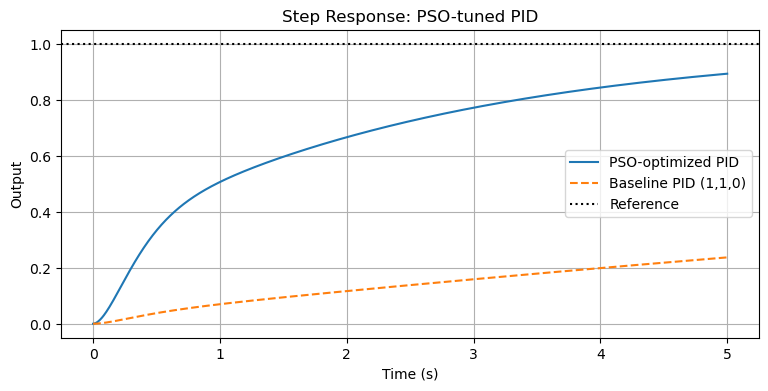

In [4]:

import numpy as np
import random
import matplotlib.pyplot as plt
from time import time

try:
    from tqdm.notebook import tqdm
except Exception:
    try:
        from tqdm import tqdm
    except Exception:
        def tqdm(x, **kwargs):
            return x

# ---------------- Plant (continuous-time) ------------------
# Plant: G(s) = 1 / (s^2 + 10 s + 20)
# State-space used for simulation:
# x1 = y, x2 = y_dot
# x1_dot = x2
# x2_dot = -10*x2 - 20*x1 + u


def simulate_pid(params, T=5.0, dt=0.005, u_sat=None):
    """
    Simulate closed-loop step response for the plant under a PID controller.
    Uses a simple fixed-step forward-Euler integration (stable for small dt).

    params: sequence-like of (Kp, Ki, Kd)
    T: total simulation time (seconds)
    dt: integration timestep
    u_sat: optional actuator saturation magnitude (float). If None, no saturation.

    Returns (t, y)
    """
    Kp, Ki, Kd = params
    n_steps = int(np.ceil(T / dt)) + 1
    t = np.linspace(0.0, T, n_steps)
    y = np.zeros(n_steps)

    # plant states
    x1 = 0.0  # y
    x2 = 0.0  # y_dot

    # controller states
    integral = 0.0
    prev_error = 1.0  # reference r=1, initial y=0 -> e=1

    for i in range(n_steps):
        error = 1.0 - x1
        integral += error * dt
        derivative = (error - prev_error) / dt if i > 0 else 0.0
        u = Kp * error + Ki * integral + Kd * derivative
        if u_sat is not None:
            u = max(min(u, u_sat), -u_sat)

        # plant dynamics (forward Euler)
        x1_dot = x2
        x2_dot = -10.0 * x2 - 20.0 * x1 + u

        x1 += x1_dot * dt
        x2 += x2_dot * dt

        y[i] = x1
        prev_error = error

    return t, y


def fitness(params, T=5.0, dt=0.005):
    """ISE (Integral of Squared Error) fitness to minimize."""
    params = np.array(params, dtype=float)
    if np.any(params < 0.0):
        return 1e9  # heavy penalty for negative gains
    t, y = simulate_pid(params, T=T, dt=dt)
    e = 1.0 - y
    J = np.trapz(e ** 2, t)
    return J


# ---------------- Particle Swarm Optimization ------------------

def pso(num_particles=15,
        max_iter=30,
        d=3,
        minx=0.0,
        maxx=10.0,
        w=0.7,
        c1=1.5,
        c2=1.5,
        T=5.0,
        dt=0.005,
        verbose=True,
        seed=None):
    """
    Simple PSO implementation tuned for PID gain search (Kp, Ki, Kd).

    Returns (best_position, best_fitness)
    """
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    swarm = []
    for _ in range(num_particles):
        pos = np.random.uniform(minx, maxx, d)
        vel = np.random.uniform(-(maxx - minx), (maxx - minx), d)
        fit = fitness(pos, T=T, dt=dt)
        swarm.append({'pos': pos, 'vel': vel, 'bestPos': pos.copy(), 'fitness': fit, 'bestFitness': fit})

    # global best
    G = min(swarm, key=lambda p: p['bestFitness'])['bestPos'].copy()
    Gfitness = min(p['bestFitness'] for p in swarm)

    iterator = range(max_iter)
    if verbose:
        iterator = tqdm(iterator, desc='PSO iters')

    for _ in iterator:
        for p in swarm:
            for dim in range(d):
                r1, r2 = random.random(), random.random()
                p['vel'][dim] = (w * p['vel'][dim]
                                  + c1 * r1 * (p['bestPos'][dim] - p['pos'][dim])
                                  + c2 * r2 * (G[dim] - p['pos'][dim]))

                # clamp velocity for numerical stability
                vmax = (maxx - minx)
                if p['vel'][dim] > vmax:
                    p['vel'][dim] = vmax
                if p['vel'][dim] < -vmax:
                    p['vel'][dim] = -vmax

                p['pos'][dim] += p['vel'][dim]
                p['pos'][dim] = np.clip(p['pos'][dim], minx, maxx)

            p['fitness'] = fitness(p['pos'], T=T, dt=dt)

            # update personal best
            if p['fitness'] < p['bestFitness']:
                p['bestFitness'] = p['fitness']
                p['bestPos'] = p['pos'].copy()

            # update global best
            if p['bestFitness'] < Gfitness:
                Gfitness = p['bestFitness']
                G = p['bestPos'].copy()

    return G, Gfitness


# ---------------- Example usage (run this cell in Jupyter) ------------------

if __name__ == "__main__":
   
    np.random.seed(0)
    random.seed(0)

 
    num_particles = 20
    max_iter = 40
    sim_T = 5.0
    sim_dt = 0.005  # reduce to 0.01 or increase dt for faster but coarser results

    t0 = time()
    best_params, best_score = pso(num_particles=num_particles,
                                 max_iter=max_iter,
                                 minx=0.0,
                                 maxx=10.0,
                                 T=sim_T,
                                 dt=sim_dt,
                                 verbose=True,
                                 seed=0)
    elapsed = time() - t0

    Kp, Ki, Kd = best_params
    print(f"Optimized PID gains: Kp={Kp:.4f}, Ki={Ki:.4f}, Kd={Kd:.4f}")
    print(f"Best ISE: {best_score:.6f} (elapsed {elapsed:.2f}s)")

    # plot optimized response vs a baseline
    t_opt, y_opt = simulate_pid(best_params, T=sim_T, dt=sim_dt)
    t_base, y_base = simulate_pid([1.0, 1.0, 0.0], T=sim_T, dt=sim_dt)

    plt.figure(figsize=(9, 4))
    plt.plot(t_opt, y_opt, label='PSO-optimized PID')
    plt.plot(t_base, y_base, '--', label='Baseline PID (1,1,0)')
    plt.axhline(1.0, color='k', linestyle=':', label='Reference')
    plt.xlabel('Time (s)')
    plt.ylabel('Output')
    plt.title('Step Response: PSO-tuned PID')
    plt.grid(True)
    plt.legend()
    plt.show()
